In [30]:
import warnings
warnings.filterwarnings('ignore')

##### **STEP 1: get market data**

---


--- Real Data for QAOA ---
Top 3 Expected Returns: [0.46240169 0.63289659 0.50140723]
Covariance Matrix Shape: (10, 10)


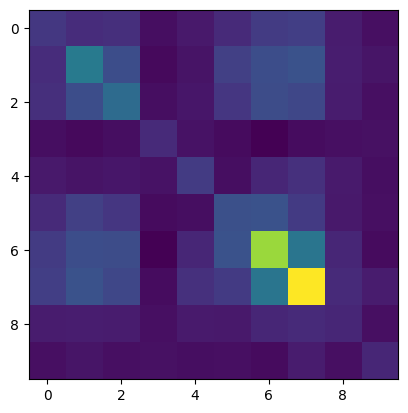

In [31]:

import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# tickers => asset
tickers = ["AAPL", "GOOGL", "MSFT", "AMZN", "TSLA", "NVDA", "JPM", "V", "JNJ", "WMT"]

data = yf.download(tickers, start="2023-01-01", end="2024-01-01", progress=False)
data = data["Close"]

# convert into daily percentage change
returns = data.pct_change().dropna()

mu = returns.mean() * 252
sigma = returns.cov() * 252

mu = mu.to_numpy()
sigma = sigma.to_numpy()


print("\n--- Real Data for QAOA ---")
print("Top 3 Expected Returns:", mu[:3])
print("Covariance Matrix Shape:", sigma.shape)


# Plot sigma
plt.imshow(sigma, interpolation="nearest")
plt.show()


##### **STEP 2: BUILD QP MODEL**

---

In [32]:

from qiskit_optimization import QuadraticProgram


budget = 4
risk_factor = 0.5
num_assets = len(tickers)
penalty=10

qp = QuadraticProgram()

for i in range(num_assets):
    qp.binary_var(name=tickers[i])

qp.minimize(
    linear = -mu,
    quadratic = risk_factor * sigma
)

qp.linear_constraint(
    linear = {tickers[i]: 1 for i in range(num_assets)},
    sense  = "==",
    rhs    = budget,
    name   = "budget_constraint"
)



<LinearConstraint: AAPL + AMZN + GOOGL + JNJ + JPM + MSFT + NVDA + TS... == 4 'budget_constraint'>

##### **STEP 3: convert into qubo form**

---

In [33]:

# ============================
# STEP 3: QUBO CONVERSION
# ============================
from qiskit_optimization.converters import QuadraticProgramToQubo

converter = QuadraticProgramToQubo()
qubo = converter.convert(qp)


##### **STEP 4: solve using VQE**

---


--- VQE RESULTS ---
Optimal binary solution: [1. 1. 0. 0. 0. 1. 1. 0. 0. 0.]
Selected portfolio: ['AAPL', 'GOOGL', 'NVDA', 'JPM']
VQE Optimal Energy: -2.4664172936517446


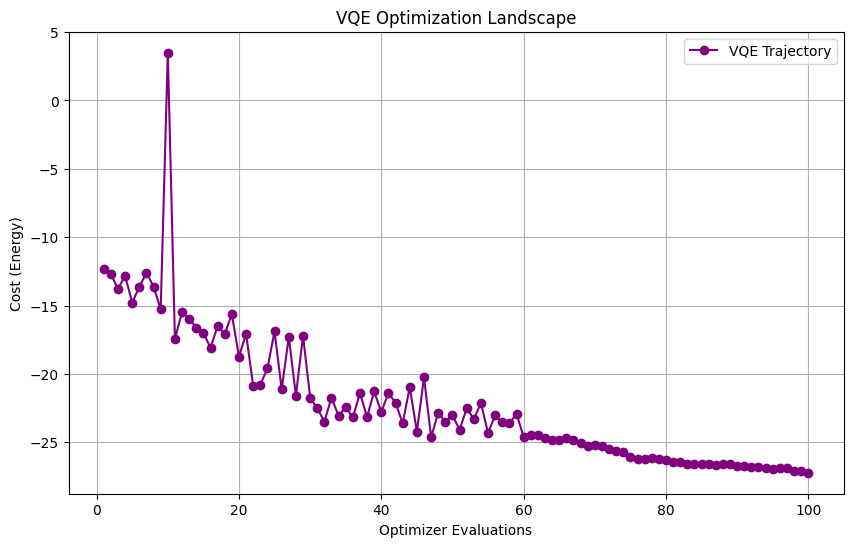

In [34]:
import matplotlib.pyplot as plt
from qiskit_algorithms import SamplingVQE
from qiskit_algorithms.optimizers import COBYLA
from qiskit.circuit.library import TwoLocal
from qiskit.primitives import Sampler
from qiskit_optimization.algorithms import MinimumEigenOptimizer

# 1. Define Callback to Store History
vqe_history = []
def vqe_callback(eval_count, params, mean, std):
    vqe_history.append((eval_count, mean))

# 2. Define the Ansatz
ansatz = TwoLocal(
    rotation_blocks='ry',
    entanglement_blocks='cz',
    entanglement='linear',
    reps=1
)

# 3. Setup VQE
vqe = SamplingVQE(
    sampler=Sampler(),
    ansatz=ansatz,
    optimizer=COBYLA(maxiter=100),
    callback=vqe_callback
)

# 4. Solve
solver = MinimumEigenOptimizer(vqe)
result = solver.solve(qubo)

print("\n--- VQE RESULTS ---")
selection = result.x
print("Optimal binary solution:", selection)

selected_tickers = [tickers[i] for i, x in enumerate(selection) if x == 1]
print("Selected portfolio:", selected_tickers)
print("VQE Optimal Energy:", result.fval)


# PLOT OPTIMIZATION LANDSCAPE
steps = [s for s, v in vqe_history]
values = [v for s, v in vqe_history]

plt.figure(figsize=(10, 6))

plt.plot(steps, values, marker="o", color='purple', label="VQE Trajectory")

plt.xlabel("Optimizer Evaluations")
plt.ylabel("Cost (Energy)")

plt.title("VQE Optimization Landscape")
plt.grid(True)
plt.legend()
plt.show()


##### **STEP 5: Result analysis**

---

In [35]:

opt_return = np.dot(mu, selection)
opt_risk   = np.sqrt(selection.T @ sigma @ selection)
sharpe = opt_return / opt_risk if opt_risk > 0 else 0

print(f"Expected Annual Return: {opt_return:.2%}")
print(f"Annual Volatility (Risk): {opt_risk:.2%}")
print(f"Sharpe Ratio: {sharpe:.4f}")
print("\n==============================")
print(" Quantum Portfolio Completed ")


Expected Annual Return: 296.35%
Annual Volatility (Risk): 99.71%
Sharpe Ratio: 2.9722

 Quantum Portfolio Completed 
